<a href="https://www.kaggle.com/code/topologically/life-expectancy-data-analysis-and-modeling?scriptVersionId=197440628" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this brief project, we'll explore a dataset containing standardized data from the World Health Organization (WHO) and we'll construct a Machine Learning model to predict the average life expectancy of a country. 

## Explaining the Dataset

The columns of the dataset are the following ones (all of them except Country are standardized):

- **Country:** name of the country.
- **Year:** year of the analysis.
- **Status:** status of the country (binary variable).
- **Life expectancy:** average life expectancy.
- **Adult mortality:** probability of dying beetwen 15 and 60 years old per 1000 population.
- **Infant deaths:** infant deaths per 1000 infants.
- **Alcohol:** average individual consumption of pure alcohol among 15+ years old people.
- **Percentage expenditure:** percent of GDP per capita spent on healthcare.
- **Hepatitis B:**  hepatitis B immunization coverage among 1-year-olds in percent.
- **Measles:** reported number of measles cases per 1000 people.
- **BMI:** average BMI of the entire population.
- **Under-five deaths:** number of under-five deaths per 1000 people.
- **Polio:** polio immunization coverage among 1-year-olds in percent.
- **Total expenditure:** general government expenditure on health as a percentage of total government expenditure.
- **Diphtheria:** diphtheria immunization coverage among 1-year-olds in percent.
- **HIV/AIDS:** scaled deaths per 1000 live births from HIV/AIDS.
- **GDP:** GDP of each country in USD.
- **Population:** total population of the country.
- **Thinness 1-19 years:** prevalence of thinness among children and adolescents for age 10 to 19 in percent.
- **Thinness 5-9 years:** prevalence of thinness among children for age 5 to 9 in percent.
- **Income composition of resources:** human development index (HDI) in terms of income composition of resources.
- **Schooling:** number of years in school on average.

In [1]:
#Importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform
import random
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")

In [2]:
#Importing dataset

X = pd.read_csv('/kaggle/input/Cleaned-Life-Exp.csv')

print(X.shape)
print(X.head())

country_col = X[['Country']]
X.drop(['Country'], axis=1, inplace = True)

(2938, 22)
       Country      Year    Status  Life expectancy  Adult Mortality  \
0  Afghanistan  1.621762 -0.459399        -0.443691         0.790238   
1  Afghanistan  1.404986 -0.459399        -0.979279         0.854614   
2  Afghanistan  1.188210 -0.459399        -0.979279         0.830473   
3  Afghanistan  0.971434 -0.459399        -1.021286         0.862660   
4  Afghanistan  0.754658 -0.459399        -1.052791         0.886801   

   infant deaths   Alcohol  percentage expenditure  Hepatitis B   Measles  \
0       0.268824 -1.133571               -0.335570    -0.635971 -0.110384   
1       0.285786 -1.133571               -0.334441    -0.755661 -0.168124   
2       0.302749 -1.133571               -0.334594    -0.675868 -0.173531   
3       0.328193 -1.133571               -0.332096    -0.556178  0.032045   
4       0.345155 -1.133571               -0.367862    -0.516281  0.051757   

   ...     Polio  Total expenditure  Diphtheria  HIV/AIDS       GDP  \
0  ... -3.268019      

The data is already cleaned and standardized.

## Exploratory Data Analysis

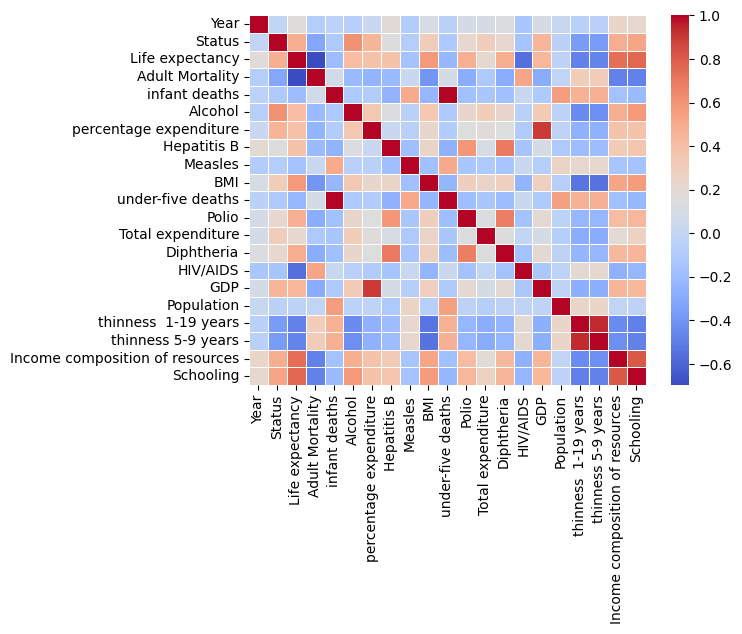

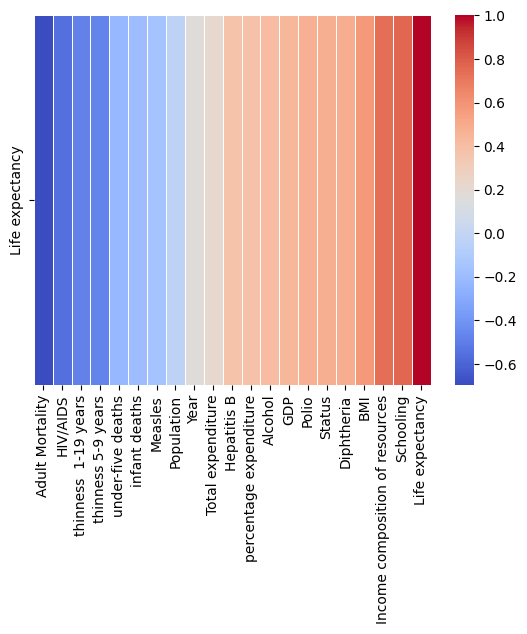

                                 Life expectancy
Adult Mortality                        -0.696561
HIV/AIDS                               -0.555889
thinness  1-19 years                   -0.481332
thinness 5-9 years                     -0.475448
under-five deaths                      -0.222293
infant deaths                          -0.196353
Measles                                -0.157428
Population                             -0.027582
Year                                    0.169590
Total expenditure                       0.216871
Hepatitis B                             0.374444
percentage expenditure                  0.381160
Alcohol                                 0.414547
GDP                                     0.443216
Polio                                   0.470382
Status                                  0.481376
Diphtheria                              0.484297
BMI                                     0.570549
Income composition of resources         0.741218
Schooling           

In [3]:
# Visualizing correlation matrix and the correlation vector with Life expectancy

corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()
sns.heatmap(corr_matrix[['Life expectancy']].sort_values(by='Life expectancy').T, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()
print(corr_matrix[['Life expectancy']].sort_values(by='Life expectancy'))

There is an unexpected positive correlation between alcohol consumption (**Alcohol**) and **Life expectancy** that will be further investigated. We notice that **Alcohol** is positively correlated with many features that are positively correlated with **Life expectancy**, like **Income composition of resources**, **Schooling**, **GDP**.  This may mean that there are some counfonders at play.

**Schooling** and **Income composition of resources** (which we'll shorten in **ICOR**) are the most positively correlated features with **Life expectancy**. However **Schooling** and **ICOR** are also positively correlated with each other, so dimensionality reduction could be applied.

## Feature Engineering

We apply PCA to several groups of highly correlated features. 

In [4]:
scaler = StandardScaler()

# PCA Income composition of resources and schooling
pca = PCA(n_components=1)
comp_and_school = X[['Income composition of resources', 'Schooling']]
pca_components = pca.fit_transform(comp_and_school)
pca_df = pd.DataFrame(pca_components, columns=['ICOR Schooling (PCA)'])
pca_df = pd.DataFrame(scaler.fit_transform(pca_df), columns=pca_df.columns)

# Remove the features
X = X.drop(columns=['Income composition of resources', 'Schooling'])
X = pd.concat([X, pca_df], axis=1)

# PCA infant deaths and under-five deaths
pca = PCA(n_components=1)
deaths_and_under_five_deaths = X[['infant deaths', 'under-five deaths']]
pca_components = pca.fit_transform(deaths_and_under_five_deaths)
pca_df = pd.DataFrame(pca_components, columns=['infant mortality (PCA)'])
pca_df = pd.DataFrame(scaler.fit_transform(pca_df), columns=pca_df.columns)

X = X.drop(columns=['infant deaths', 'under-five deaths'])
X = pd.concat([X, pca_df], axis=1)

# PCA percentage expenditure and GDP
pca = PCA(n_components=1)
deaths_and_under_five_deaths = X[['percentage expenditure', 'GDP']]
pca_components = pca.fit_transform(deaths_and_under_five_deaths)
pca_df = pd.DataFrame(pca_components, columns=['Health Expenditure (PCA)'])
pca_df = pd.DataFrame(scaler.fit_transform(pca_df), columns=pca_df.columns)

X = X.drop(columns=['percentage expenditure', 'GDP'])
X = pd.concat([X, pca_df], axis=1)

# PCA BMI and thinness 1-19 years and thinness 5-9 years
pca = PCA(n_components=2)
BMI_and_thinness = X[['BMI', 'thinness  1-19 years', 'thinness 5-9 years']]
pca_components = pca.fit_transform(BMI_and_thinness)
pca_df = pd.DataFrame(pca_components, columns=['BMI and thinness (PCA 1)', 'BMI and thinness (PCA 2)'])
pca_df = pd.DataFrame(scaler.fit_transform(pca_df), columns=pca_df.columns)

X = X.drop(columns=['BMI', 'thinness  1-19 years', 'thinness 5-9 years'])
X = pd.concat([X, pca_df], axis=1)

print(X.head())

       Year    Status  Life expectancy  Adult Mortality   Alcohol  \
0  1.621762 -0.459399        -0.443691         0.790238 -1.133571   
1  1.404986 -0.459399        -0.979279         0.854614 -1.133571   
2  1.188210 -0.459399        -0.979279         0.830473 -1.133571   
3  0.971434 -0.459399        -1.021286         0.862660 -1.133571   
4  0.754658 -0.459399        -1.052791         0.886801 -1.133571   

   Hepatitis B   Measles     Polio  Total expenditure  Diphtheria  HIV/AIDS  \
0    -0.635971 -0.110384 -3.268019           0.889486   -0.730578 -0.323445   
1    -0.755661 -0.168124 -1.048077           0.897493   -0.857092 -0.323445   
2    -0.675868 -0.173531 -0.877312           0.877476   -0.772749 -0.323445   
3    -0.556178  0.032045 -0.663856           1.033609   -0.646235 -0.323445   
4    -0.516281  0.051757 -0.621165           0.773387   -0.604064 -0.323445   

   Population  ICOR Schooling (PCA)  infant mortality (PCA)  \
0    0.343993              0.654934            

We reduced the three features **BMI, thinness 1-19 years, thinness 5-9 years** to two features and not just one because of the following cumulative variance study.

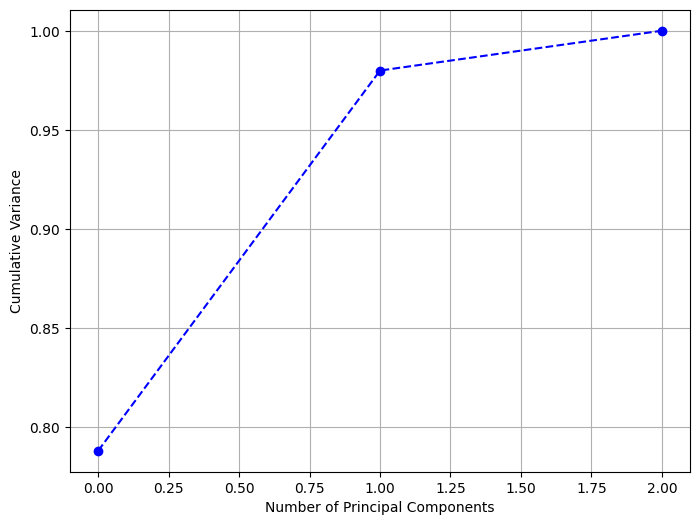

In [5]:
pca = PCA()
pca_components = pca.fit_transform(BMI_and_thinness)

explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

As we can see, the cumulative variance decreases under 80% with just one component, so two components is a better choice.

Now we plot again the correlation vector with Life Expectancy.

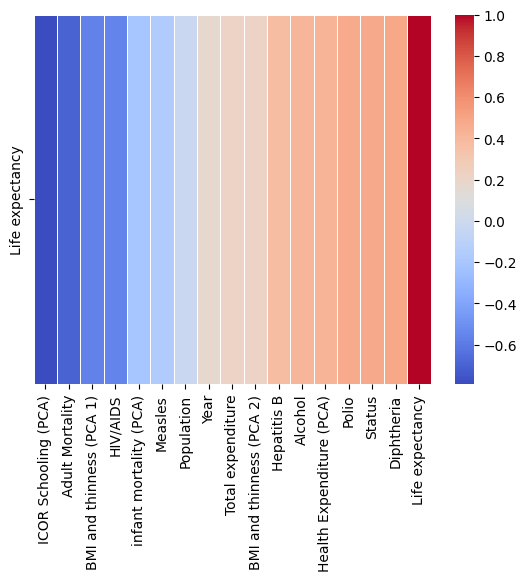

                          Life expectancy
ICOR Schooling (PCA)            -0.792601
Adult Mortality                 -0.696561
BMI and thinness (PCA 1)        -0.565374
HIV/AIDS                        -0.555889
infant mortality (PCA)          -0.209500
Measles                         -0.157428
Population                      -0.027582
Year                             0.169590
Total expenditure                0.216871
BMI and thinness (PCA 2)         0.220482
Hepatitis B                      0.374444
Alcohol                          0.414547
Health Expenditure (PCA)         0.420505
Polio                            0.470382
Status                           0.481376
Diphtheria                       0.484297
Life expectancy                  1.000000


In [6]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix[['Life expectancy']].sort_values(by='Life expectancy').T, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()
print(corr_matrix[['Life expectancy']].sort_values(by='Life expectancy'))

We notice that **ICOR Schooling (PCA)** is negatively correlated with **Life Expectancy**. This isn't surprising, because PCA doesn't preserve the sign of the correlation between features. However, to improve the interpretability of the dataset, we'll change the sign of ICOR Schooling (PCA).

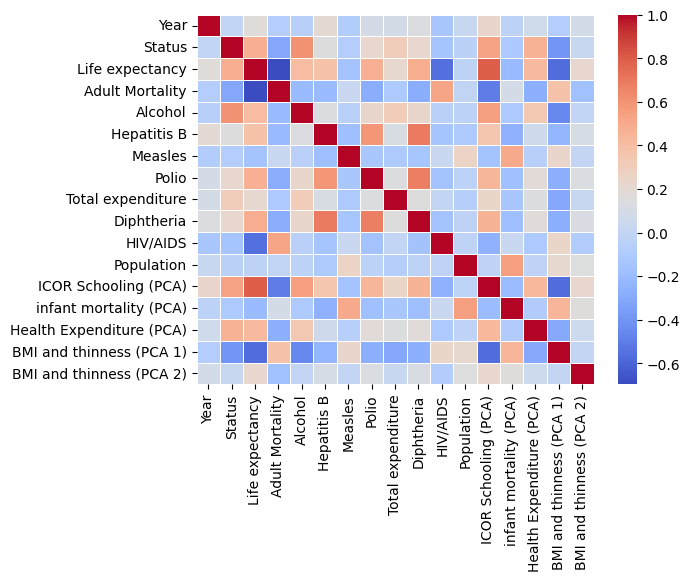

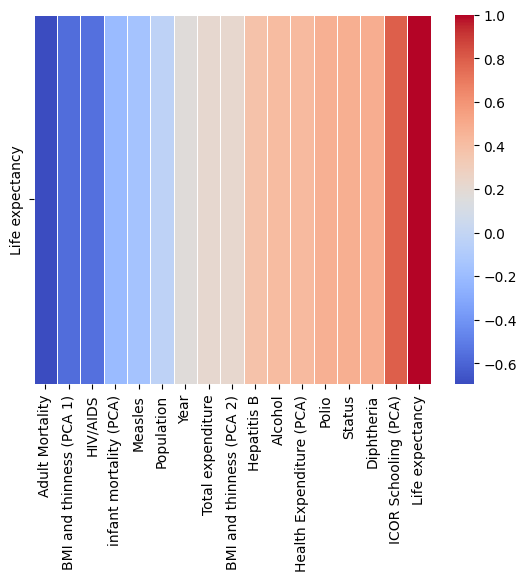

                          Life expectancy
Adult Mortality                 -0.696561
BMI and thinness (PCA 1)        -0.565374
HIV/AIDS                        -0.555889
infant mortality (PCA)          -0.209500
Measles                         -0.157428
Population                      -0.027582
Year                             0.169590
Total expenditure                0.216871
BMI and thinness (PCA 2)         0.220482
Hepatitis B                      0.374444
Alcohol                          0.414547
Health Expenditure (PCA)         0.420505
Polio                            0.470382
Status                           0.481376
Diphtheria                       0.484297
ICOR Schooling (PCA)             0.792601
Life expectancy                  1.000000


In [7]:
X['ICOR Schooling (PCA)'] = -X['ICOR Schooling (PCA)']

corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()
sns.heatmap(corr_matrix[['Life expectancy']].sort_values(by='Life expectancy').T, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()
print(corr_matrix[['Life expectancy']].sort_values(by='Life expectancy'))

## Explaining the positive correlation between Alcohol and Life Expectancy

It is unlikely that the positive correlation between alcohol consumption (**Alcohol**) and **Life expectancy** is due to causality. Our hypothesis is that more developed countries (which have a longer life expectancy) consume more alcohol than underdeveloped ones. 

This hyphothesis is suggested by the positive correlation between **Alcohol** and **ICOR Schooling (PCA)**. 

To test this hypothesis, we divided our dataset into three equally sized groups based on the index **ICOR Schooling (PCA)** , with the first group containing countries with the lowest **ICOR Schooling (PCA)** values and the last group containing those with the highest.



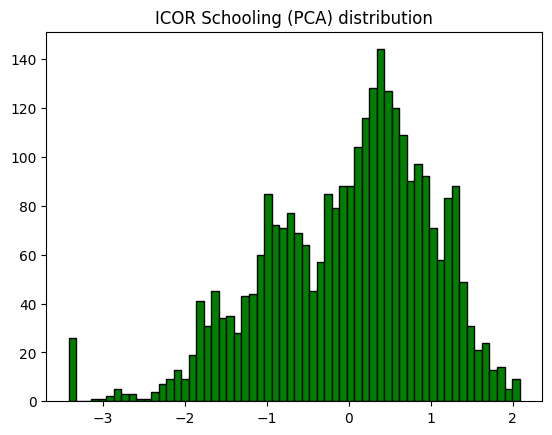

In [8]:
plt.hist(X['ICOR Schooling (PCA)'], bins=60, color='green', edgecolor='black')
plt.title('ICOR Schooling (PCA) distribution')
X['Tertile'] = pd.qcut(X['ICOR Schooling (PCA)'], q=4, labels=False)

X0 = X[X['Tertile'] == 0]
X1 = X[X['Tertile'] == 1]
X2 = X[X['Tertile'] == 2]

X0.drop('Tertile', axis=1, inplace = True)
X1.drop('Tertile', axis=1, inplace = True)
X2.drop('Tertile', axis=1, inplace = True)
X.drop('Tertile', axis=1, inplace = True)


Now we study separately the correlation vectors with **Life Expectancy** of the dataframes **X0,X1,X2**.

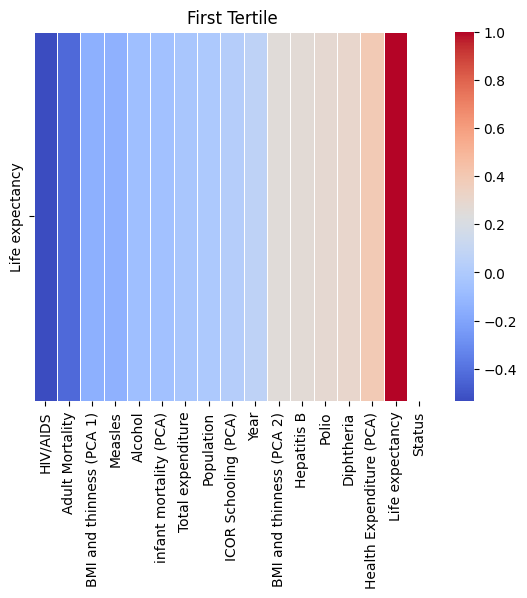

                          Life expectancy
HIV/AIDS                        -0.535275
Adult Mortality                 -0.427933
BMI and thinness (PCA 1)        -0.149741
Measles                         -0.145220
Alcohol                         -0.072594
infant mortality (PCA)          -0.060034
Total expenditure               -0.026267
Population                      -0.008146
ICOR Schooling (PCA)             0.027958
Year                             0.066346
BMI and thinness (PCA 2)         0.250672
Hepatitis B                      0.265604
Polio                            0.280450
Diphtheria                       0.301509
Health Expenditure (PCA)         0.394218
Life expectancy                  1.000000
Status                                NaN


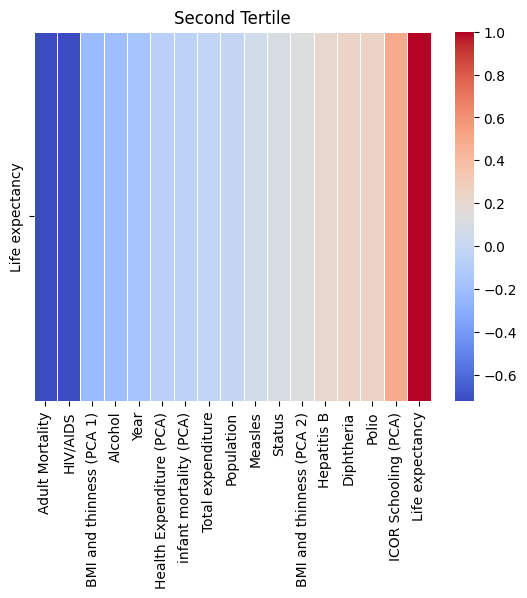

                          Life expectancy
Adult Mortality                 -0.723901
HIV/AIDS                        -0.719410
BMI and thinness (PCA 1)        -0.226925
Alcohol                         -0.208321
Year                            -0.167956
Health Expenditure (PCA)        -0.067706
infant mortality (PCA)          -0.053263
Total expenditure               -0.016920
Population                      -0.014065
Measles                          0.066865
Status                           0.099498
BMI and thinness (PCA 2)         0.136019
Hepatitis B                      0.209282
Diphtheria                       0.240105
Polio                            0.246737
ICOR Schooling (PCA)             0.493344
Life expectancy                  1.000000


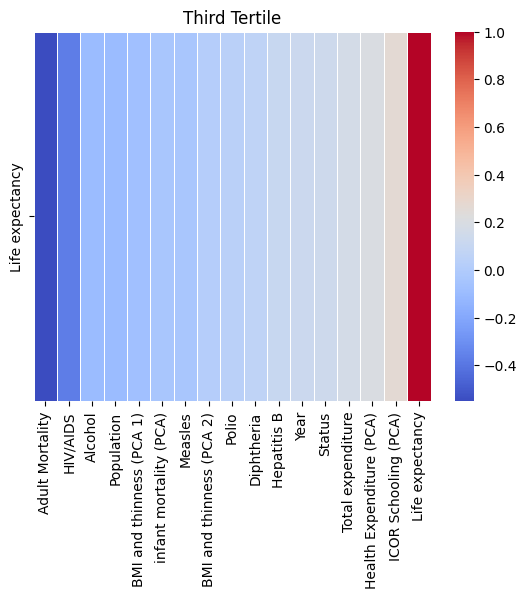

                          Life expectancy
Adult Mortality                 -0.551567
HIV/AIDS                        -0.375349
Alcohol                         -0.100473
Population                      -0.098111
BMI and thinness (PCA 1)        -0.077671
infant mortality (PCA)          -0.039766
Measles                         -0.038481
BMI and thinness (PCA 2)         0.014697
Polio                            0.039681
Diphtheria                       0.061840
Hepatitis B                      0.108719
Year                             0.125782
Status                           0.137942
Total expenditure                0.169358
Health Expenditure (PCA)         0.200110
ICOR Schooling (PCA)             0.264547
Life expectancy                  1.000000


In [9]:

corr_matrix0 = X0.corr()
sns.heatmap(corr_matrix0[['Life expectancy']].sort_values(by='Life expectancy').T, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('First Tertile')
plt.show()
print(corr_matrix0[['Life expectancy']].sort_values(by='Life expectancy'))

corr_matrix1 = X1.corr()
sns.heatmap(corr_matrix1[['Life expectancy']].sort_values(by='Life expectancy').T, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Second Tertile')
plt.show()
print(corr_matrix1[['Life expectancy']].sort_values(by='Life expectancy'))

corr_matrix2 = X2.corr()
sns.heatmap(corr_matrix2[['Life expectancy']].sort_values(by='Life expectancy').T, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Third Tertile')
plt.show()
print(corr_matrix2[['Life expectancy']].sort_values(by='Life expectancy'))


*(The Nan value of the **Status** correlation in the tertile **X0** is due to the fact that all of the countries in **X0** have the same status)*

As expected in each of these groups the alcohol consumption (**Alcohol**) is weakly negatively correlated with **Life Expectancy**. This result confirms our hyphothesis. It's also interesting to notice that in the first tertile (**X0**) the feature **Health Expenditure (PCA)** is the most highly correlated with **Life Expectancy** (instead of **ICOR Schooling (PCA)**). 

## Constructing a Machine Learning model for Life Expectancy

Since we are working with tabular data, we try a XGBRegressor model and a Random Forest model. To avoid overfitting, we'll use a cross-validation with 5 folds.

In [10]:
xgb_model = XGBRegressor()
y = X['Life expectancy']
X.drop(columns=['Life expectancy'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

xgb_scores = -1 *cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("CV score (XGBRegressor):",xgb_scores.mean())

rf_model = RandomForestRegressor(random_state=22)
rf_scores = -1 *cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("CV score (RandomForestRegressor):",rf_scores.mean())

CV score (XGBRegressor): 0.044391093704635495
CV score (RandomForestRegressor): 0.04138867822542769


The CV scores of the two models are similar.

Let's test our models.

In [11]:
xgb_model.fit(X_train,y_train)
y_xgbpred = xgb_model.predict(X_test)
print("Mean squared error (XGBRegressor):", mean_squared_error(y_test, y_xgbpred))

rf_model.fit(X_train,y_train)
y_rfpred = rf_model.predict(X_test)
print("Mean squared error (RandomForestRegressor):", mean_squared_error(y_test, y_rfpred))

Mean squared error (XGBRegressor): 0.043835729116136875
Mean squared error (RandomForestRegressor): 0.03814810543895698


The MSE values of the two models are similar. We tune the hyperparameters of both models to get the best version of each model.

In [12]:
#Tuning hyperparameters of XGBRegressor

param_dist_xgb = {
    'n_estimators': np.arange(200, 400, 50),  
    'max_depth': np.arange(3, 10, 1),           
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.6, 1.0, 5),      
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0, 0.5, 5),            
    'reg_alpha': np.logspace(-3, 1, 5),         
    'reg_lambda': np.logspace(-3, 1, 5)         
}

xgb_model = XGBRegressor()

random_search_xgb = RandomizedSearchCV(estimator=xgb_model,
                                    param_distributions=param_dist_xgb,
                                    n_iter=60,                     
                                    scoring='neg_mean_squared_error', 
                                    cv=5,                                                                
                                    random_state=22)   

random_search_xgb.fit(X_train, y_train)

print("Best parameters (XGBRegressor):")
print(random_search_xgb.best_params_)

print("Best CV score (XGBRegressor):", -1*random_search_xgb.best_score_)

best_xgb_model = random_search_xgb.best_estimator_

Best parameters (XGBRegressor):
{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.042222222222222223, 'gamma': 0.0, 'colsample_bytree': 0.9}
Best CV score (XGBRegressor): 0.040097800819056166


In [13]:
#Tuning hyperparameters of RandomForestRegressor

param_dist_rf = {
    'n_estimators': np.arange(100, 300, 50),     
    'max_depth': np.arange(10, 110, 10),         
    'min_samples_split': np.arange(2, 10, 2),    
    'min_samples_leaf': np.arange(1, 10, 2),                      
}

rf_model = RandomForestRegressor(random_state=22)

random_search_rf = RandomizedSearchCV(estimator=rf_model,
                                    param_distributions=param_dist_rf,
                                    n_iter=60,                     
                                    scoring='neg_mean_squared_error', 
                                    cv=5,                                                                
                                    random_state=22)   

random_search_rf.fit(X_train, y_train)

print("Best parameters (RandomForestRegressor):")
print(random_search_rf.best_params_)

print("Best CV score (RandomForestRegressor):", -1*random_search_rf.best_score_)

best_rf_model = random_search_rf.best_estimator_

Best parameters (RandomForestRegressor):
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 60}
Best CV score (RandomForestRegressor): 0.04080547755907833


After hyperparameter tuning, the two models are still very similar in terms of CV scores. Let's see the predictions of the two models.

In [14]:
best_rf_model.fit(X_train,y_train)
y_rfpred = best_rf_model.predict(X_test)
print("Mean squared error (RandomForestRegressor):", mean_squared_error(y_test, y_rfpred))

best_xgb_model.fit(X_train,y_train)
y_xgbpred = best_xgb_model.predict(X_test)
print("Mean squared error (XGBRegressor):", mean_squared_error(y_test, y_xgbpred))

Mean squared error (RandomForestRegressor): 0.03750700237977969
Mean squared error (XGBRegressor): 0.038755549987021846


The best model is RandomForestRegressor.

In [15]:
best_model = best_rf_model

Now we can determine the importance of the features in the prediction of **Life Expectancy**.

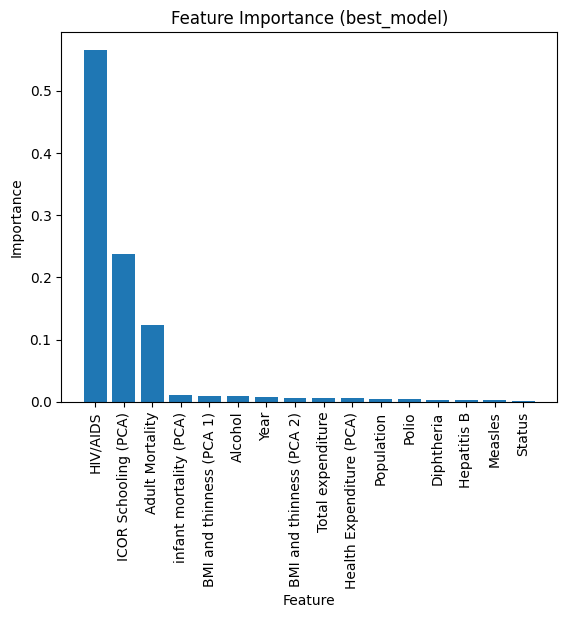

In [16]:
importances = best_model.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (best_model)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

According to our model, **HIV/AIDS** is by far the most important predictive feature of **Life expectancy**. However, when examining the correlation vector with **Life expectancy**, this result seems counterintuitive, as **HIV/AIDS** is not the most correlated feature. 

Nevertheless, there is no contradiction: correlation is merely a measure of linear dependency and cannot adequately describe more complex relationships. Additionally, multicollinearity among the features may obscure the true influence of each feature in the correlation vector.

To further support our result, we can see also the feature importances attributed by the XGBRegressor model also agree with this result.

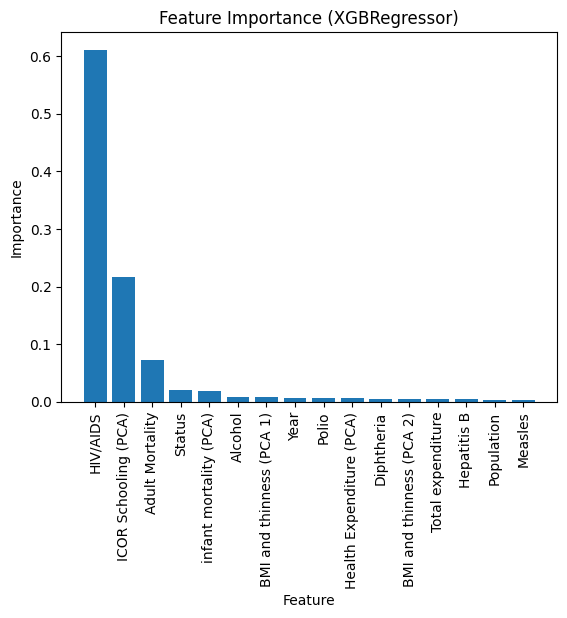

In [17]:
importances = best_xgb_model.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (XGBRegressor)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

## Conclusions

In this project we developed a Machine Learning model that predicts the (standardized) **Life expectancy** with good accuracy (MSE = 0.0375). According to our model **HIV/AIDS**  is the best predictive feature of Life expectancy (followed by **ICOR Schooling (PCA)** and **Adult Mortality**). We also determined that the positive correlation between alcohol consumption (**Alcohol**) and **Life expectancy** is due to the fact that more developed countries tend to drink more alcohol. In fact the correlation between **Alcohol** and **Life expectancy** becomes weakly negative if we group the rows by **ICOR Schooling (PCA)**.